In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
#from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn


In [2]:
def my_plot_style():
   
    params = {'legend.fontsize': 20,
             'axes.labelsize': 20,
             'axes.titlesize':20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'xtick.major.size':5,
              'xtick.minor.size':2.5,
             'ytick.major.size':5,
              'ytick.minor.size':2.5,
             'figure.facecolor':'w',
             #'lines.linewidth' : 1.5,
              'xtick.major.width':1.5,
              'ytick.major.width':1.5,
              'xtick.minor.width':1.5,
              'ytick.minor.width':1.5,
              'axes.linewidth':1.5,
              'xtick.direction':'in',
              'ytick.direction':'in',
             'ytick.labelleft':True,
              'text.usetex' : False,
             'font.family': 'sans-serif'}
  
    plt.rcParams.update(params)

In [3]:
directory_everest = '/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/'
everest_all = Table.read(directory_everest+'ztile-sv1-dark-cumulative.fits')
everest_bright = Table.read(directory_everest+'ztile-sv1-bright-cumulative.fits')


new_catalog_everest = everest_all['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                              ,'FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','PHOTSYS'].to_pandas()
new_catalog_everest_bright = everest_bright['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                              ,'FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','PHOTSYS'].to_pandas()

new_catalog_everest=new_catalog_everest.append(new_catalog_everest_bright)


In [4]:
fuji_all = pd.read_csv('/global/homes/t/tlan/projects/DESI_VI_new/DESI_VI_paper_fuji/Fuji_latest_220216.csv')
# Compiled from /global/cfs/cdirs/desi/spectro/redux/f1

In [5]:
def give_me_combine_catalog(target_name,everest_data,denali_data):
    if target_name=='BGS':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
        dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
    
    elif target_name=='LRG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
        dataname = 'allVItiles_LRGzinfo_wVI.fits'
    
    elif target_name=='ELG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/ELG/'
        dataname = 'allVItiles_ELGzinfo_wVI.fits'

    elif target_name=='QSO':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/QSO/'
        dataname = 'allVItiles_QSOzinfo_wVI.fits'
            
    VI_data = Table.read(diretory+dataname)
    VI_data = VI_data[(VI_data['subset']=='deep') & (VI_data['subset']!='All') & ((VI_data['N_VI']>0))]
    VI_data = VI_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                        ,'FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','best_z','best_quality','N_VI','all_VI_comments','merger_comment'].to_pandas()

        
    catalog_match = everest_data.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    final_match_catalog = catalog_match[catalog_match['TILEID']==catalog_match['TILEID_VI']]

    final_match_catalog = final_match_catalog.merge(denali_data,on='TARGETID',how='left',suffixes=("","_denali"))
    final_match_catalog = final_match_catalog[final_match_catalog['TILEID']==final_match_catalog['TILEID_denali']]
    final_match_catalog['dz_fuji']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_everest']=abs(final_match_catalog['Z_denali']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_cascades']=abs(final_match_catalog['Z_VI']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

    return final_match_catalog

In [6]:
def give_me_dz_inconsistent_statistics(data):
    good_data = data.loc[(data['best_quality']>=2.5) & ((data['ZWARN']==0) | (data['ZWARN'] == 4))]# & (data['MASKBITS']==0)]
    all_n = len(data['best_quality'])
    total_good_n = len(good_data)
    total_dz_inconsistent_fuji = len(good_data.loc[good_data['dz_fuji']>=0.0033])
    total_dz_inconsistent_everest = len(good_data.loc[good_data['dz_everest']>=0.0033])
    total_dz_inconsistent_cascades = len(good_data.loc[good_data['dz_cascades']>=0.0033])
    print('Number of best quality>=2.5 & zwarn==0 or 4 spectra:%0.0f (out of %0.0f VI spectra)' % (total_good_n,all_n))
    print('Number of spectra with inconsistent redshifts vs VI best z')
    print('Fuji: %0.0f (%0.1f%%)' % (total_dz_inconsistent_fuji,total_dz_inconsistent_fuji*1.0/total_good_n*100.))
    print('Everest: %0.0f (%0.1f%%)' % (total_dz_inconsistent_everest,total_dz_inconsistent_everest*1.0/total_good_n*100.))
    print('Cascades: %0.0f (%0.1f%%)' % (total_dz_inconsistent_cascades,total_dz_inconsistent_cascades*1.0/total_good_n*100.))
    return {'dz_fuji':good_data.loc[good_data['dz_fuji']>=0.0033],'dz_everest':good_data.loc[good_data['dz_everest']>=0.0033]}

In [7]:
def give_me_zwarn_statistics(data):
    good_zwarn_data = data.loc[(data['ZWARN']==0)]# | (data['ZWARN']==4)]
    all_n = len(data['best_quality'])
    total_good_zwarn = len(good_zwarn_data)
    total_zwarn_best_quality = len(good_zwarn_data.loc[good_zwarn_data['best_quality']>=2.5])
    total_zwarn_best_quality_not_passed = len(good_zwarn_data.loc[good_zwarn_data['best_quality']<2.5])

    total_dz_inconsistent_fuji = len(good_zwarn_data.loc[(good_zwarn_data['best_quality']>=2.5) & (good_zwarn_data['dz_fuji']>=0.0033)])
    #print(np.array(good_zwarn_data.loc[(good_zwarn_data['best_quality']>=2.5) & (good_zwarn_data['dz_fuji']>=0.0033)]['FIBER']))
    total_dz_inconsistent_everest = len(good_zwarn_data.loc[(good_zwarn_data['best_quality']>=2.5) & (good_zwarn_data['dz_everest']>=0.0033)])
    total_dz_inconsistent_cascades = len(good_zwarn_data.loc[(good_zwarn_data['best_quality']>=2.5) & (good_zwarn_data['dz_cascades']>=0.0033)])
    print('Number of zwarn==0 spectra:%0.0f (out of %0.0f VI spectra)' % (total_good_zwarn,all_n))
    print('Number of zwarn==0 & best_quality>=2.5 spectra:%0.0f' % (total_zwarn_best_quality))
    print('Number of zwarn==0 & best_quality<2.5 spectra:%0.0f (%0.1f%%)' % (total_zwarn_best_quality_not_passed,total_zwarn_best_quality_not_passed/total_good_zwarn*100.))

    print('Number of spectra with inconsistent redshifts vs VI best z (zwarn==0 and best_quality>=2.5)')
    print('Fuji: %0.0f (%0.1f%%)' % (total_dz_inconsistent_fuji,total_dz_inconsistent_fuji*1.0/total_good_zwarn*100.))
    print('Everest: %0.0f (%0.1f%%)' % (total_dz_inconsistent_everest,total_dz_inconsistent_everest*1.0/total_good_zwarn*100.))
    print('Cascades: %0.0f (%0.1f%%)' % (total_dz_inconsistent_cascades,total_dz_inconsistent_cascades*1.0/total_good_zwarn*100.))
    return {'dz_fuji':good_zwarn_data.loc[good_zwarn_data['dz_fuji']>=0.0033],'dz_everest':good_zwarn_data.loc[good_zwarn_data['dz_everest']>=0.0033]}



In [8]:
def main_survey_selection(data,target_type):
    new_catalog = data.copy()
    new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
    new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['GTOT']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['GFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['RFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['ZFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']

    new_catalog['W1']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
    
    new_catalog['RZ']=new_catalog['rmag']-new_catalog['zmag']
    new_catalog['GR']=new_catalog['gmag']-new_catalog['rmag']
    new_catalog['GW1']=new_catalog['gmag']-new_catalog['W1']
    new_catalog['color']=(new_catalog['zmag']-new_catalog['W1'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
    new_catalog['ZW1']=new_catalog['zmag']-new_catalog['W1']
    new_catalog['RW1']=new_catalog['rmag']-new_catalog['W1']

    if target_type=='ELG_main':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))
    
    elif target_type=='ELG_top':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.3))
    
    elif target_type=='ELG_low':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']>-1.2*new_catalog['RZ']+1.3) & (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))

        
    elif target_type=='BGS_main':
        #SV3_selection = (
        #    ((new_catalog['PHOTSYS']==b'S') & ((new_catalog['RFIB']<20.75) | ((new_catalog['RFIB']<21.5) & (new_catalog['color']>0)))) |            
        #    ((new_catalog['PHOTSYS']==b'N') & ((new_catalog['RFIB']<20.75+0.04) | ((new_catalog['RFIB']<21.5+0.04) & (new_catalog['color']>0)))))   
        new_catalog['color']=new_catalog['color']-0.048
        SV3_selection = (
            ((new_catalog['RFIB']<20.75+0.04) | ((new_catalog['RFIB']<21.5+0.04) & (new_catalog['color']>0))))
        #deltachi2_selection = new_catalog['DELTACHI2']>40
        #SV3_selection = SV3_selection & deltachi2_selection
    
    elif target_type=='LRG_main':
        

        SV3_selection = (
            (new_catalog['ZFIB']<21.6) &
            (new_catalog['ZW1']>0.8*new_catalog['RZ']-0.6) & 
            ((new_catalog['GW1']>2.9) | (new_catalog['RW1']>1.8)) &
            (((new_catalog['RW1']>(new_catalog['W1']-17.14)*1.8) & (new_catalog['RW1']>(new_catalog['W1']-16.33)))  | (new_catalog['RW1']>3.3))
            )  
       # deltachi2_selection = (new_catalog['Z']>0.4) & (new_catalog['Z']<1.4) & (new_catalog['DELTACHI2']>15)
       # SV3_selection = SV3_selection & deltachi2_selection    
    return new_catalog[SV3_selection]

In [9]:
BGS_data = give_me_combine_catalog('BGS',fuji_all,new_catalog_everest)
LRG_data = give_me_combine_catalog('LRG',fuji_all,new_catalog_everest)
ELG_data = give_me_combine_catalog('ELG',fuji_all,new_catalog_everest)
QSO_data = give_me_combine_catalog('QSO',fuji_all,new_catalog_everest)

In [10]:
BGS_data

,Unnamed: 0,TARGETID,Z,ZERR,TILEID,TARGET_RA,TARGET_DEC,PHOTSYS,DELTACHI2,CHI2,...,FLUX_G_denali,FLUX_Z_denali,EBV_denali,ZWARN_denali,FIBER_denali,FIBERTOTFLUX_G,PHOTSYS_denali,dz_fuji,dz_everest,dz_cascades
0,0,39633345017023828,0.168625,2.678670e-06,80613,106.432586,56.781829,b'N',4534.566896,9706.385729,...,6.336541,14.912650,0.050537,0,2500,1.565639,b'N',2.109013e-05,0.000022,0.000042
1,1,39633345021216442,0.342315,2.811066e-05,80613,106.720219,56.768930,b'N',1766.205580,9049.581424,...,4.291854,41.303493,0.047956,0,2501,0.804465,b'N',1.133042e-05,0.000010,0.000029
2,4,39633348343105726,0.130618,3.760418e-06,80613,106.696477,56.925696,b'N',1900.764008,9145.377686,...,11.562769,34.383518,0.050355,0,2504,1.322463,b'N',1.624389e-05,0.000017,0.000022
3,7,39633345017024813,0.276206,3.368724e-06,80613,106.533476,56.834601,b'N',7204.954266,9776.213202,...,2.978225,11.567602,0.050414,0,2507,1.343500,b'N',4.806665e-06,0.000004,0.000018
4,9,39633348343106215,0.167812,3.890967e-06,80613,106.753555,56.948843,b'N',8933.282926,10143.431834,...,53.256691,205.724579,0.049713,0,2509,3.528072,b'N',1.002840e-05,0.000011,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,493,39633324632707064,0.167524,2.473750e-06,80613,106.075834,55.318528,b'N',26321.595713,15016.883858,...,32.987141,117.789253,0.055086,0,993,5.189163,b'N',6.498388e-05,0.000066,0.000034
2897,495,39633324624315696,0.417001,2.787412e-05,80613,104.981003,55.150647,b'N',2971.373582,9695.412845,...,1.704525,22.553574,0.052947,0,995,0.728119,b'N',6.024638e-07,0.000003,0.000011
2898,497,39633324632706782,0.320259,3.221357e-06,80613,106.048251,55.285682,b'N',13318.001902,16373.312765,...,2.395923,16.195503,0.054460,0,997,1.343871,b'N',3.092701e-05,0.000030,0.000026
2899,498,39633324624317601,0.114877,8.112605e-07,80613,105.166679,55.282851,b'N',58270.887775,13288.538956,...,11.230797,26.191750,0.054555,0,998,5.542210,b'N',2.079855e-05,0.000020,0.000017


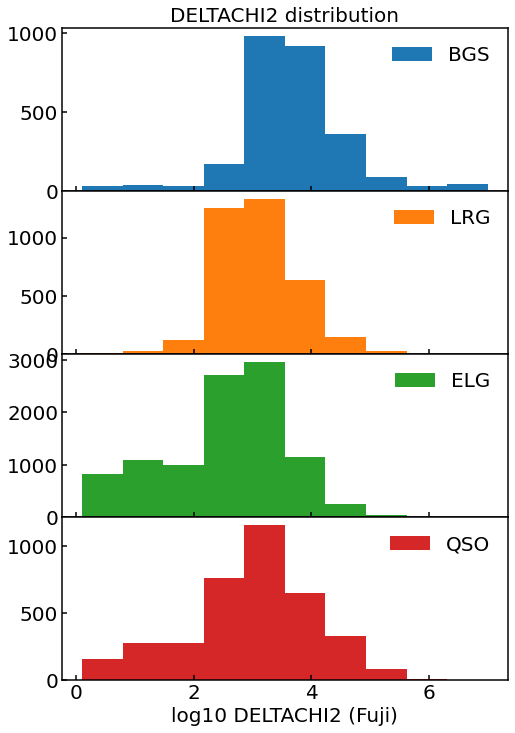

In [11]:
my_plot_style()
plt.figure(figsize=(8,12))
plt.subplots_adjust(hspace=0.0)
plt.subplot(4,1,1)
plt.hist(np.log10(BGS_data['DELTACHI2']),range=(0.1,7),label='BGS')
plt.title('DELTACHI2 distribution')
plt.legend(frameon=False)
plt.subplot(4,1,2)
plt.hist(np.log10(LRG_data['DELTACHI2']),range=(0.1,7),label='LRG',color='C1')
plt.legend(frameon=False)
plt.subplot(4,1,3)
plt.hist(np.log10(ELG_data['DELTACHI2']),range=(0.1,7),label='ELG',color='C2')
plt.legend(frameon=False)
plt.subplot(4,1,4)
plt.hist(np.log10(QSO_data['DELTACHI2']),range=(0.1,7),label='QSO',color='C3')
plt.xlabel('log10 DELTACHI2 (Fuji)',fontsize=20)
plt.legend(frameon=False)

In [20]:
print('SV1 selection')
print('---------------------------------------')
print('')
print('BGS')
BGS_dz = give_me_dz_inconsistent_statistics(BGS_data)
print('')
print('LRG ')
LRG_dz = give_me_dz_inconsistent_statistics(LRG_data)
print('')
print('ELG')
ELG_dz = give_me_dz_inconsistent_statistics(ELG_data)
print('')
print('QSO')
QSO_dz = give_me_dz_inconsistent_statistics(QSO_data)

SV1 selection
---------------------------------------

BGS
Number of best quality>=2.5 & zwarn==0 or 4 spectra:2585 (out of 2718 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 15 (0.6%)
Everest: 22 (0.9%)
Cascades: 54 (2.1%)

LRG 
Number of best quality>=2.5 & zwarn==0 or 4 spectra:3454 (out of 3561 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 38 (1.1%)
Everest: 63 (1.8%)
Cascades: 76 (2.2%)

ELG
Number of best quality>=2.5 & zwarn==0 or 4 spectra:7762 (out of 10315 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 113 (1.5%)
Everest: 178 (2.3%)
Cascades: 181 (2.3%)

QSO
Number of best quality>=2.5 & zwarn==0 or 4 spectra:3195 (out of 3761 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 182 (5.7%)
Everest: 220 (6.9%)
Cascades: 213 (6.7%)


In [25]:
np.sort(BGS_dz['dz_fuji']['TARGETID'])

array([39633324657870665, 39633324657871262, 39633324657872917,
       39633328118170553, 39633331528139161, 39633331540724976,
       39633334942305917, 39633338301940715, 39633338335494607,
       39633338335497905, 39633341682551782, 39633344996051874,
       39633351627247805, 39633354923969942, 39633354928164022])

In [26]:
print('SV1 selection')
print('---------------------------------------')
print('')
print('BGS')
_ = give_me_zwarn_statistics(BGS_data)
print('')
print('LRG ')
_ = give_me_zwarn_statistics(LRG_data)
print('')
print('ELG')
_ = give_me_zwarn_statistics(ELG_data)
print('')
print('QSO')
_ = give_me_zwarn_statistics(QSO_data)

SV1 selection
---------------------------------------

BGS
Number of zwarn==0 spectra:2659 (out of 2718 VI spectra)
Number of zwarn==0 & best_quality>=2.5 spectra:2583
Number of zwarn==0 & best_quality<2.5 spectra:76 (2.9%)
Number of spectra with inconsistent redshifts vs VI best z (zwarn==0 and best_quality>=2.5)
Fuji: 13 (0.5%)
Everest: 21 (0.8%)
Cascades: 53 (2.0%)

LRG 
Number of zwarn==0 spectra:3532 (out of 3561 VI spectra)
Number of zwarn==0 & best_quality>=2.5 spectra:3446
Number of zwarn==0 & best_quality<2.5 spectra:86 (2.4%)
Number of spectra with inconsistent redshifts vs VI best z (zwarn==0 and best_quality>=2.5)
Fuji: 34 (1.0%)
Everest: 59 (1.7%)
Cascades: 72 (2.0%)

ELG
Number of zwarn==0 spectra:8895 (out of 10315 VI spectra)
Number of zwarn==0 & best_quality>=2.5 spectra:7716
Number of zwarn==0 & best_quality<2.5 spectra:1179 (13.3%)
Number of spectra with inconsistent redshifts vs VI best z (zwarn==0 and best_quality>=2.5)
Fuji: 84 (0.9%)
Everest: 154 (1.7%)
Cascades:

In [27]:
BGS_dz['dz_fuji'].to_csv('220216_Fuji_vs_VI_SV1_inconsistent_z_BGS.csv')
LRG_dz['dz_fuji'].to_csv('220216_Fuji_vs_VI_SV1_inconsistent_z_LRG.csv')
ELG_dz['dz_fuji'].to_csv('220216_Fuji_vs_VI_SV1_inconsistent_z_ELG.csv')
QSO_dz['dz_fuji'].to_csv('220216_Fuji_vs_VI_SV1_inconsistent_z_QSO.csv')

In [15]:
BGS_dz['dz_fuji']

,Unnamed: 0,TARGETID,Z,ZERR,TILEID,TARGET_RA,TARGET_DEC,PHOTSYS,DELTACHI2,CHI2,...,FLUX_G_denali,FLUX_Z_denali,EBV_denali,ZWARN_denali,FIBER_denali,FIBERTOTFLUX_G,PHOTSYS_denali,dz_fuji,dz_everest,dz_cascades
424,202,39633324657872917,1.031733,0.000007,80613,108.741207,55.148405,b'N',146454.667885,7.182170e+06,...,111.019585,120.489929,0.072177,0,4702,703.131042,b'N',1.031327,1.031442,1.033255e+00
473,301,39633324657871262,0.493012,0.000139,80613,108.590605,55.249933,b'N',9.237035,8.612717e+03,...,3.126332,8.725419,0.077899,0,4801,0.082503,b'N',0.078217,0.342875,1.343970e-05
477,307,39633324657870665,1.657300,0.000055,80613,108.538786,55.316971,b'N',64.066605,1.874242e+04,...,0.672829,28.464396,0.078403,0,4807,1.004717,b'N',1.657300,1.657371,2.091779e-05
516,355,39633331528139161,1.368292,0.000123,80613,107.060011,55.771496,b'N',90.970690,1.596341e+04,...,1.455987,17.842995,0.053735,0,4855,0.575274,b'N',0.555324,0.555240,5.747871e-01
1001,166,39633338335494607,1.625640,0.000004,80613,108.852060,56.342247,b'N',60.855903,7.254528e+05,...,55.389336,46.963543,0.073292,0,3666,114.997559,b'N',1.625508,0.509606,1.636365e+00
1083,336,39633338335497905,1.485391,0.000040,80613,109.191025,56.318935,b'N',256.825310,1.145571e+04,...,4.288056,13.027859,0.079000,0,3836,0.896465,b'N',1.058806,1.058769,1.058698e+00
1662,314,39633338301940715,0.941719,0.000048,80613,105.312713,56.256568,b'N',152.043360,1.297057e+04,...,9.803484,35.019482,0.059960,0,1814,2.115024,b'N',0.837966,0.837921,1.021587e+00
1756,475,39633344996051874,1.035448,0.000008,80613,104.115233,56.659627,b'N',6840.642312,4.006892e+05,...,10.670530,27.247051,0.055207,0,1975,83.259544,b'N',1.035753,1.035736,1.033924e+00
1794,56,39633354928164022,0.522254,0.000007,80613,108.106151,57.407629,b'N',26533.623531,1.614809e+06,...,89.163162,24.254236,0.056841,0,3056,433.499573,b'N',0.522330,0.000060,5.085851e-01
1798,63,39633354923969942,1.680235,0.000009,80613,107.726881,57.534608,b'N',11315.320605,4.300548e+05,...,3.969985,66.908859,0.050542,0,3063,78.217323,b'N',1.679967,1.679994,1.684348e+00


Deltachi2 and Fuji Redrock distribution for objects with inconsistent redshifts


(-0.1, 3.8)

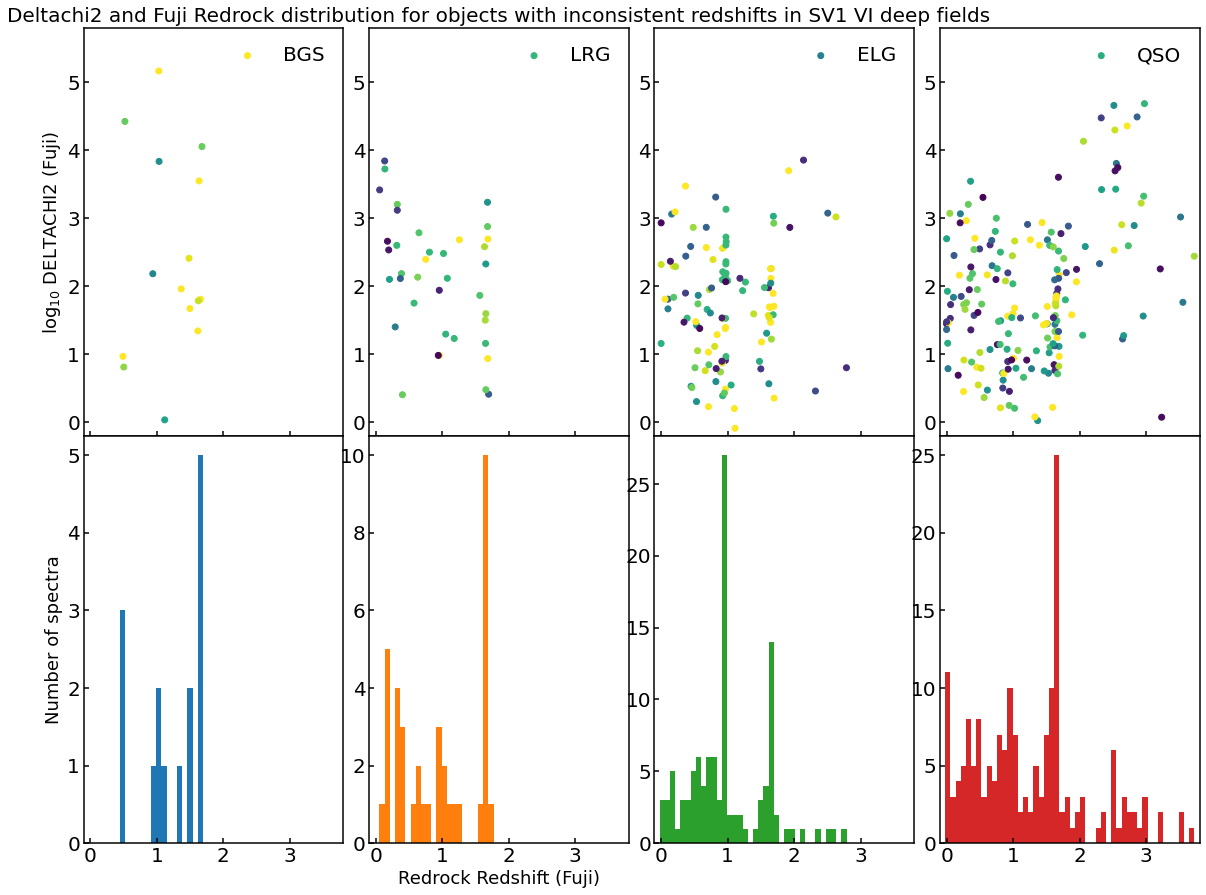

In [16]:
print('Deltachi2 and Fuji Redrock distribution for objects with inconsistent redshifts')

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.,wspace=0.1)
my_plot_style()
plt.subplot(2,4,1)
plt.ylabel('$\\rm log_{10}$ DELTACHI2 (Fuji)',fontsize=18)
plt.scatter(BGS_dz['dz_fuji']['Z'],np.log10(BGS_dz['dz_fuji']['DELTACHI2']),label='BGS',c=BGS_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.legend(frameon=False)
plt.subplot(2,4,2)
plt.title('Deltachi2 and Fuji Redrock distribution for objects with inconsistent redshifts in SV1 VI deep fields')
plt.scatter(LRG_dz['dz_fuji']['Z'],np.log10(LRG_dz['dz_fuji']['DELTACHI2']),label='LRG',c=LRG_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)

plt.legend(frameon=False)
plt.subplot(2,4,3)
plt.scatter(ELG_dz['dz_fuji']['Z'],np.log10(ELG_dz['dz_fuji']['DELTACHI2']),label='ELG',c=ELG_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.legend(frameon=False)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
#plt.subplot(1,2,2)
#plt.scatter(BGS_dz['dz_everest']['Z'],np.log10(BGS_dz['dz_everest']['DELTACHI2']))
#plt.ylim(0,6)
plt.legend(frameon=False)
plt.subplot(2,4,4)
plt.scatter(QSO_dz['dz_fuji']['Z'],np.log10(QSO_dz['dz_fuji']['DELTACHI2']),label='QSO',c=QSO_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.legend(frameon=False)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.subplot(2,4,5)
plt.ylabel('Number of spectra',fontsize=18)
_ = plt.hist(BGS_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),label='BGS')
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
#plt.legend(frameon=False)
plt.subplot(2,4,6)
_ = plt.hist(LRG_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),color='C1',label='LRG')
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.xlabel('Redrock Redshift (Fuji)',fontsize=18)
#plt.legend(frameon=False)
plt.subplot(2,4,7)
_ = plt.hist(ELG_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),color='C2',label='ELG')
#plt.legend(frameon=False)
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.subplot(2,4,8)
_ = plt.hist(QSO_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),color='C3',label='QSO')
#plt.legend(frameon=False)
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)

#plt.subplot(1,2,2)
#plt.scatter(BGS_dz['dz_everest']['Z'],np.log10(BGS_dz['dz_everest']['DELTACHI2']))
#plt.ylim(0,6)


Text(0.5, 1.0, 'FIBER ID distribution for inconsistent redshifts')

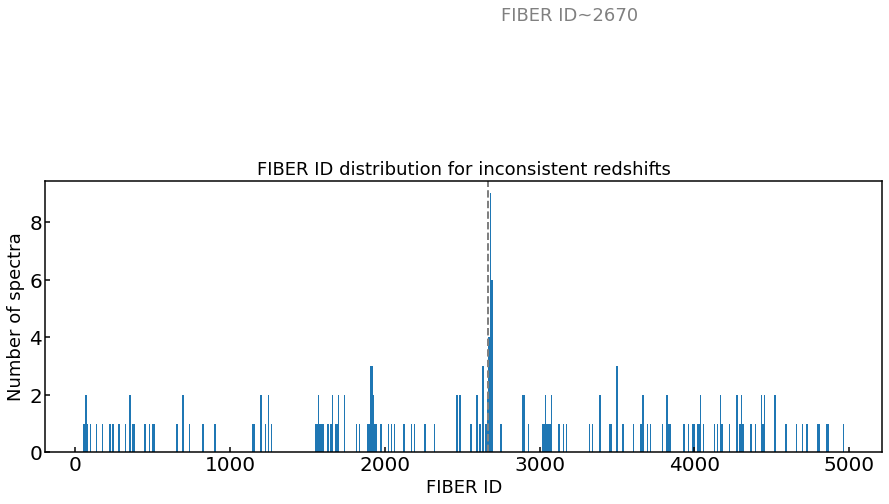

In [66]:
inconsistent_fiber_id = np.append(np.array(BGS_dz['dz_fuji']['FIBER']),np.array(LRG_dz['dz_fuji']['FIBER']))
inconsistent_fiber_id = np.append(inconsistent_fiber_id,np.array(ELG_dz['dz_fuji']['FIBER']))
plt.figure(figsize=(15,5))
_ = plt.hist(inconsistent_fiber_id,bins=500)
plt.xlabel('FIBER ID',fontsize=18)
plt.ylabel('Number of spectra',fontsize=18)
plt.axvline(2670,ls='--',color='grey',lw=2)
plt.text(2750,15,'FIBER ID~2670',fontsize=18,color='grey')
plt.title('FIBER ID distribution for inconsistent redshifts',fontsize=18)

In [17]:
BGS_main = main_survey_selection(BGS_data,'BGS_main')
LRG_main = main_survey_selection(LRG_data,'LRG_main')
ELG_main = main_survey_selection(ELG_data,'ELG_main')
ELG_top = main_survey_selection(ELG_data,'ELG_top')
ELG_low = main_survey_selection(ELG_data,'ELG_low')

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Best VI redshift')

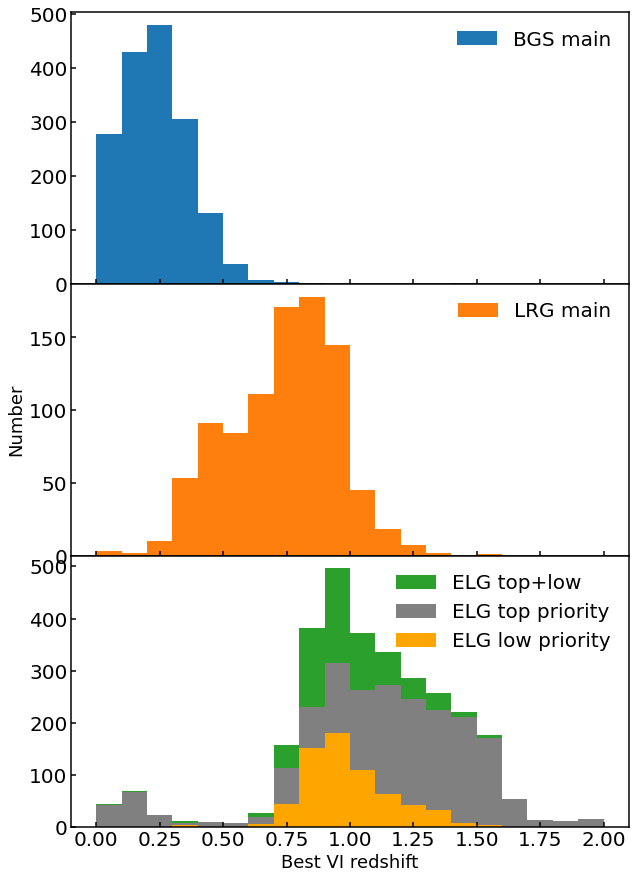

In [18]:
plt.figure(figsize=(10,15))
my_plot_style()
plt.subplots_adjust(hspace=0.)
plt.subplot(3,1,1)
plt.hist(BGS_main['best_z'][BGS_main['best_quality']>=2.5],range=(0,2),bins=20,label='BGS main')
plt.legend(frameon=False)
plt.subplot(3,1,2)
plt.ylabel('Number',fontsize=18)
plt.hist(LRG_main['best_z'][LRG_main['best_quality']>=2.5],range=(0,2),bins=20,color='C1',label='LRG main')
plt.legend(frameon=False)
plt.subplot(3,1,3)

plt.hist(ELG_main['best_z'][ELG_main['best_quality']>=2.5],range=(0,2),bins=20,color='C2',label='ELG top+low',alpha=1)
plt.hist(ELG_top['best_z'][ELG_top['best_quality']>=2.5],range=(0,2),bins=20,label='ELG top priority',color='grey',alpha=1)
plt.hist(ELG_low['best_z'][ELG_low['best_quality']>=2.5],range=(0,2),bins=20,label='ELG low priority',color='orange',alpha=1)
plt.legend(frameon=False)
plt.xlabel('Best VI redshift',fontsize=18)

In [19]:
print('Main survey selection')
print('---------------------------------------')
print('')
print('BGS')
BGS_dz = give_me_dz_inconsistent_statistics(BGS_main)
print('')
print('LRG ')
LRG_dz = give_me_dz_inconsistent_statistics(LRG_main)
print('')
print('ELG top+low priority')
ELG_dz = give_me_dz_inconsistent_statistics(ELG_main)
print('')
print('ELG top priority')

ELG_dz = give_me_dz_inconsistent_statistics(ELG_top)
print('')
print('ELG low priority')

ELG_dz = give_me_dz_inconsistent_statistics(ELG_low)

Main survey selection
---------------------------------------

BGS
Number of best quality>=2.5 & zwarn==0 or 4 spectra:1744 (out of 1761 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 6 (0.3%)
Everest: 6 (0.3%)
Cascades: 23 (1.3%)

LRG 
Number of best quality>=2.5 & zwarn==0 or 4 spectra:923 (out of 933 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 9 (1.0%)
Everest: 10 (1.1%)
Cascades: 14 (1.5%)

ELG top+low priority
Number of best quality>=2.5 & zwarn==0 or 4 spectra:3058 (out of 3565 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 25 (0.8%)
Everest: 39 (1.3%)
Cascades: 41 (1.3%)

ELG top priority
Number of best quality>=2.5 & zwarn==0 or 4 spectra:2404 (out of 2897 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 22 (0.9%)
Everest: 34 (1.4%)
Cascades: 36 (1.5%)

ELG low priority
Number of best quality>=2.5 & zwarn==0 or 4 spectra:654 (out of 668 VI spectra)
Number of 